In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emd
from scipy.signal import hilbert
import warnings

print("Hello world")



Hello world


In [2]:
try:
    data = pd.read_csv('./log_data.csv')
    depth = data['depth'].values
    gamma_log_signal = data['gamma'].values
    print(f"Data loaded successfully from 'gamma-log.csv'.")
    print(f"Depth range: {depth.min()} to {depth.max()}")
except Exception as e:
    print(f"An error occurred: {e}")
    print("File not found")



Data loaded successfully from 'gamma-log.csv'.
Depth range: 2700.0203 to 2920.0203


In [3]:
depth_diff = np.diff(depth)
if not np.allclose(depth_diff, depth_diff[0]):
    print("Warning: Depth intervals are not constant. Frequency calculation assumes variable intervals.")
    sampling_interval = depth_diff # Use individual intervals
else:
    sampling_interval = depth_diff[0] # Use constant interval
    print(f"Constant depth sampling interval: {sampling_interval:.4f}")

In [4]:
imfs = emd.sift.sift(gamma_log_signal)
print(imfs.shape)


(1320, 7)


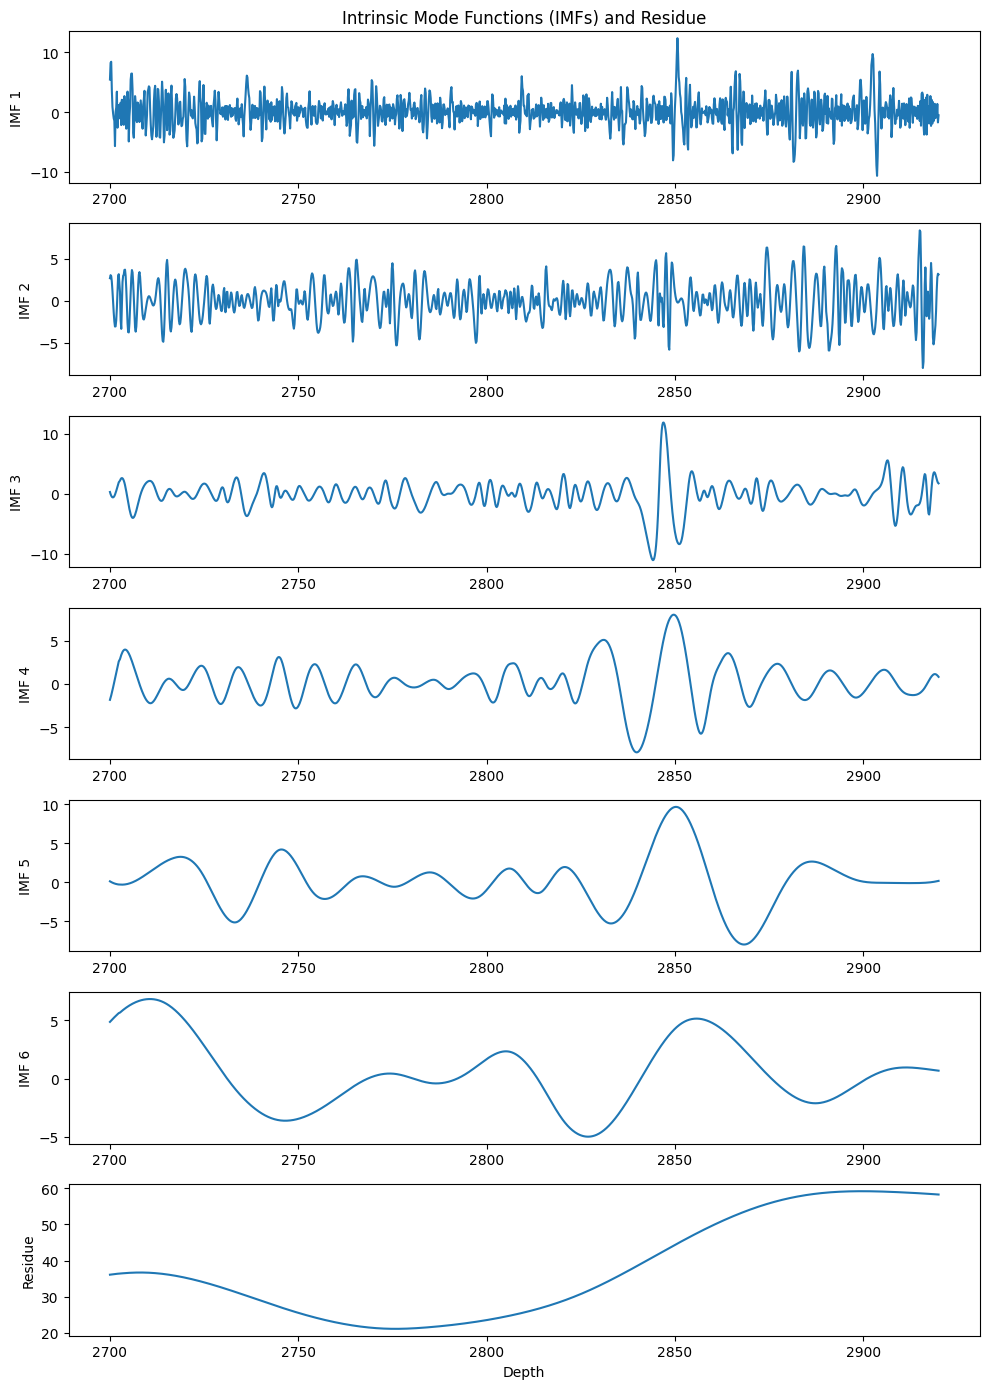

In [5]:
nIMFs = imfs.shape[1]  # number of IMFs (including residue)

plt.figure(figsize=(10, 2 * nIMFs))

for i in range(nIMFs):
    plt.subplot(nIMFs, 1, i + 1)
    plt.plot(depth, imfs[:, i])
    plt.ylabel(f'IMF {i + 1}' if i < nIMFs - 1 else 'Residue')
    if i == 0:
        plt.title("Intrinsic Mode Functions (IMFs) and Residue")
    if i == nIMFs - 1:
        plt.xlabel('Depth')

plt.tight_layout()
plt.show()

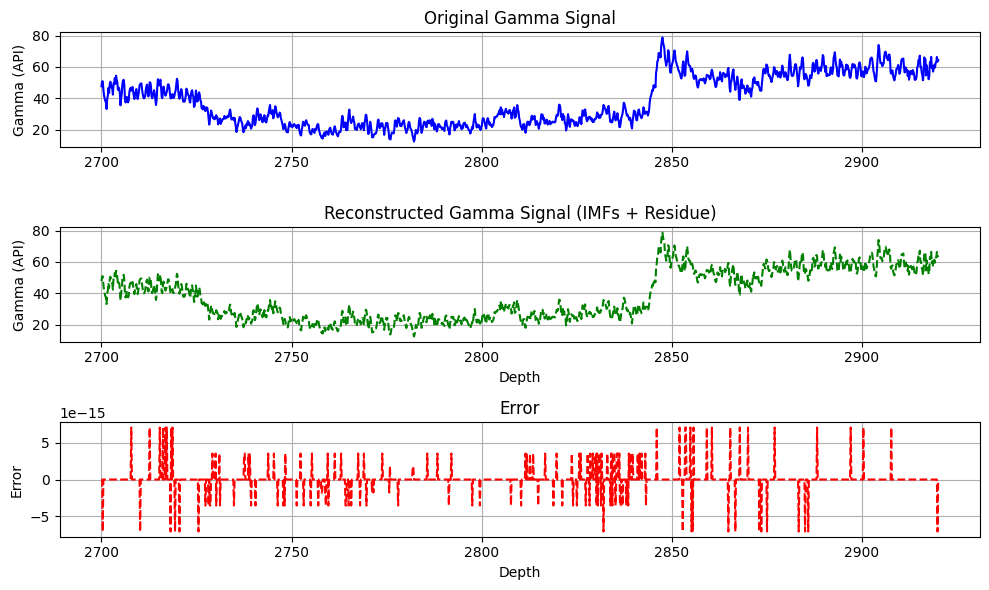

In [6]:
# Reconstruct the signal
reconstructedIMFs = np.sum(imfs[:, :-1], axis=1)
residue = imfs[:, -1]
reconstructedSignal = reconstructedIMFs + residue

error = gamma_log_signal - reconstructedSignal

# Create subplots
plt.figure(figsize=(10, 6))

# Plot original gamma
plt.subplot(3, 1, 1)
plt.plot(depth, gamma_log_signal, color='blue')
plt.title("Original Gamma Signal")
plt.ylabel("Gamma (API)")
plt.grid(True)

# Plot reconstructed signal
plt.subplot(3, 1, 2)
plt.plot(depth, reconstructedSignal, color='green', linestyle='--')
plt.title("Reconstructed Gamma Signal (IMFs + Residue)")
plt.xlabel("Depth")
plt.ylabel("Gamma (API)")
plt.grid(True)

# Plot error
plt.subplot(3, 1, 3)
plt.plot(depth, error, color='red', linestyle='--')
plt.title("Error")
plt.xlabel("Depth")
plt.ylabel("Error")
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
instantaneous_frequencies = []
instantaneous_amplitudes = []
analytic_signals = []

for i in range(nIMFs):
    analytic_signal = hilbert(imfs[:, i])
    analytic_signals.append(analytic_signal)

    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.diff(instantaneous_phase) / (np.diff(depth))
    
    # Pad the frequency array to match the original length (optional, depends on use case)
    # Here, we repeat the first value to make lengths match for easy plotting
    instantaneous_frequency = np.insert(instantaneous_frequency, 0, instantaneous_frequency[0])

    # freq are positive
    instantaneous_frequency[instantaneous_frequency < 0] = 0

    # amp calc
    instantaneous_amplitude = np.abs(analytic_signal)

    instantaneous_frequencies.append(instantaneous_frequency)
    instantaneous_amplitudes.append(instantaneous_amplitude)
    

print("Hilbert Transform and calculations complete.")

# Convert lists to numpy arrays for easier handling
instantaneous_freqs = np.array(instantaneous_frequencies)
instantaneous_amps = np.array(instantaneous_amplitudes)


Hilbert Transform and calculations complete.


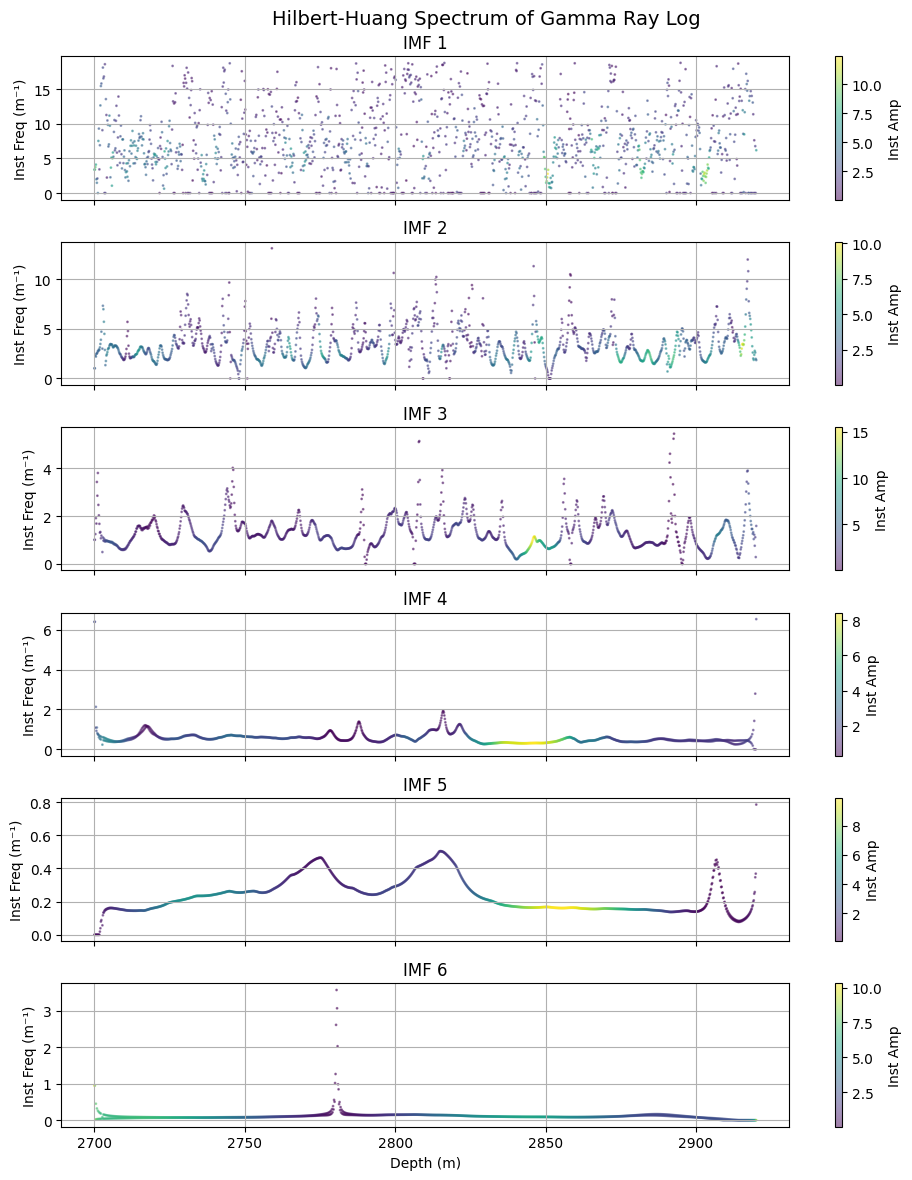

In [44]:
total_amplitude = 0
fig, axs = plt.subplots(nIMFs - 1, 1, figsize=(10, 2 * (nIMFs - 1)), sharex=True)
fig.suptitle("Hilbert-Huang Spectrum of Gamma Ray Log", fontsize=14)

for i in range(nIMFs - 1):
    ax = axs[i]  # Get the axis for current subplot

    sc = ax.scatter(
        depth,
        instantaneous_freqs[i],
        s=1,
        c=instantaneous_amps[i],
        cmap='viridis',
        alpha=0.5
    )

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('Inst Amp')

    ax.set_ylabel("Inst Freq (m⁻¹)")
    ax.set_title(f"IMF {i+1}")

    if i == (nIMFs - 2):  # Last one
        ax.set_xlabel("Depth (m)")

    ax.grid(True)



plt.tight_layout()
plt.show()


Analyzing IMFs 1 to 6 (excluding residual IMF 7).
  IMF 1: Found 339 peaks.
  IMF 2: Found 126 peaks.
  IMF 3: Found 49 peaks.
  IMF 4: Found 20 peaks.
  IMF 5: Found 8 peaks.
  IMF 6: Found 5 peaks.

Linear Regression Results (log(Im) vs m):
  Slope (ln(rho)): 0.8643
  Intercept (ln(k)): 0.6207
  R-squared: 0.9913
  P-value: 2.842e-05

Estimated Heterogeneity Index (rho): 2.3733


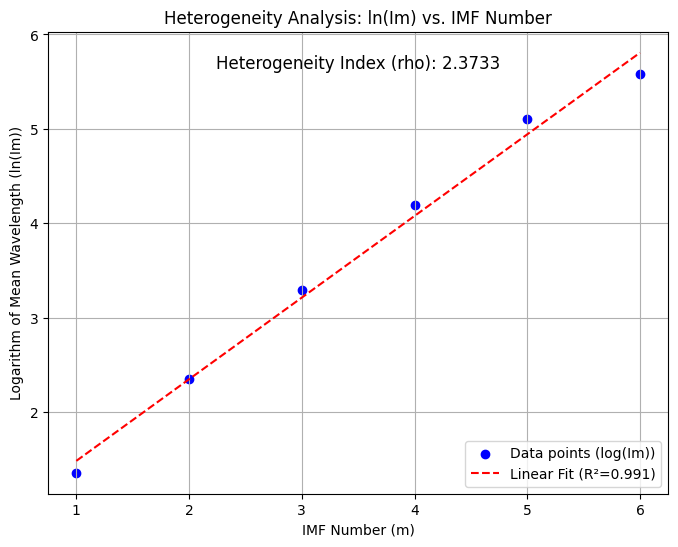

In [47]:
from scipy.signal import find_peaks
from scipy.stats import linregress

mean_wavelengths = []
imf_numbers_for_analysis = []
imf_indices_used = [] # Keep track of which IMF indices were successfully processed

total_points = len(depth)

num_imfs_to_analyze = nIMFs - 1
if num_imfs_to_analyze < 2:
    print("Error: Need at least 2 IMFs (excluding residual) for regression.")
    # Handle this case as needed, maybe exit or skip analysis
else:
    print(f"Analyzing IMFs 1 to {num_imfs_to_analyze} (excluding residual IMF {nIMFs}).")
    for i in range(num_imfs_to_analyze):
        imf = imfs[:,i]
        imf_number = i + 1

        # Find peaks in the current IMF
        peaks_indices, _ = find_peaks(imf)
        num_peaks = len(peaks_indices)

        print(f"  IMF {imf_number}: Found {num_peaks} peaks.")

        # Calculate mean wavelength (Im)
        if num_peaks > 0:
            # Ratio of total number of points to total number of peaks
            Im = total_points / num_peaks
            mean_wavelengths.append(Im)
            imf_numbers_for_analysis.append(imf_number)
            imf_indices_used.append(i)
        else:
            print(f"  IMF {imf_number}: No peaks found. Skipping this IMF for heterogeneity analysis.")


# Linear Regression between log(Im) and m 
if len(imf_numbers_for_analysis) >= 2: # Need at least two points for linear regression
    m_values = np.array(imf_numbers_for_analysis)
    Im_values = np.array(mean_wavelengths)

    # Calculate the logarithm of the mean wavelengths
    log_Im_values = np.log(Im_values) # Using natural logarithm (ln)

    # Perform linear regression: log(Im) = slope * m + intercept
    # slope = ln(rho) based on the derivation ln(Im) = ln(k) + m*ln(rho)
    slope, intercept, r_value, p_value, std_err = linregress(m_values, log_Im_values)

    # Calculate the heterogeneity index rho = antilog(slope) = exp(slope)
    rho = np.exp(slope)
    r_squared = r_value**2

    print(f"\nLinear Regression Results (log(Im) vs m):")
    print(f"  Slope (ln(rho)): {slope:.4f}")
    print(f"  Intercept (ln(k)): {intercept:.4f}")
    print(f"  R-squared: {r_squared:.4f}")
    print(f"  P-value: {p_value:.4g}")

    print(f"\nEstimated Heterogeneity Index (rho): {rho:.4f}")

    # Plot log(Im) vs m 
    plt.figure(figsize=(8, 6))
    plt.scatter(m_values, log_Im_values, label='Data points (log(Im))', marker='o', color='blue')

    # Create the regression line points
    regression_line = slope * m_values + intercept
    plt.plot(m_values, regression_line, label=f'Linear Fit (R²={r_squared:.3f})', color='red', linestyle='--')
    
    # show heterogeneity index
    plt.text(0.5, 0.95, f'Heterogeneity Index (rho): {rho:.4f}', transform=plt.gca().transAxes, fontsize=12, ha='center', va='top')


    plt.xlabel("IMF Number (m)")
    plt.ylabel("Logarithm of Mean Wavelength (ln(Im))")
    plt.title("Heterogeneity Analysis: ln(Im) vs. IMF Number")
    plt.legend()
    plt.grid(True)
    plt.xticks(m_values) # Ensure ticks are at the actual IMF numbers used
    plt.show()

else:
    print("\nCould not perform heterogeneity analysis: Not enough valid IMFs with peaks found.")